## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import timeit

import math
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

## Data Understanding

In [2]:
df = pd.read_csv('train.csv', sep = ',')
df_test = pd.read_csv('test.csv', sep = ',')

In [3]:
df.head()

,brand,model,year,mileage,engine,engine_size,transmission,automatic_transmission,fuel_type,drivetrain,...,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,interior_color,exterior_color,price
0,Mazda,CX-9 Touring,2022.0,6580.0,2.5L I4 16V GDI DOHC Turbo,2.5,6-Speed Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,Black,Snowflake White Pearl,36789
1,Alfa,Romeo Stelvio 4DR SUV AWD,2018.0,62717.0,Twin Turbo Premium Unleaded V-6 2.9 L/176,2.9,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,Black,Rosso Competizione Tri-Coat,39993
2,Chevrolet,Silverado 1500 Limited LT,2022.0,15463.0,5.3L V8 16V GDI OHV,5.3,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Jet Black,Silver Ice Metallic,46986
3,Land,Rover Range Rover P400 SE,2022.0,1281.0,3.0L I6 24V GDI DOHC Turbo,3.0,Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,Ebony,Fuji White,141999
4,Mitsubishi,Outlander Sport 2.0 SE,2021.0,36727.0,2.0L I4 16V MPFI DOHC,2.0,Automatic CVT,1.0,Gasoline,Front-wheel Drive,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,Black,White,21595


### Data Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19109 entries, 0 to 19108
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   brand                        19107 non-null  object 
 1   model                        19107 non-null  object 
 2   year                         19107 non-null  float64
 3   mileage                      19107 non-null  float64
 4   engine                       19062 non-null  object 
 5   engine_size                  17860 non-null  float64
 6   transmission                 19004 non-null  object 
 7   automatic_transmission       19107 non-null  float64
 8   fuel_type                    19107 non-null  object 
 9   drivetrain                   19107 non-null  object 
 10  min_mpg                      16103 non-null  float64
 11  max_mpg                      16103 non-null  float64
 12  damaged                      18940 non-null  float64
 13  first_owner     

In [5]:
target_var = 'price'
binary_vars = [col for col in df.columns if df[col].nunique() == 2]
cat_vars = [ col for col in df.columns if col not in binary_vars and df[col].dtype == "object"]
num_vars = [ col for col in df.columns if col not in binary_vars and df[col].dtype in ['int64', 'float64'] and col != target_var]

In [6]:
target_var

'price'

In [7]:
binary_vars

['automatic_transmission',
 'damaged',
 'first_owner',
 'personal_using',
 'turbo',
 'alloy_wheels',
 'adaptive_cruise_control',
 'navigation_system',
 'power_liftgate',
 'backup_camera',
 'keyless_start',
 'remote_start',
 'sunroof/moonroof',
 'automatic_emergency_braking',
 'stability_control',
 'leather_seats',
 'memory_seat',
 'third_row_seating',
 'apple_car_play/android_auto',
 'bluetooth',
 'usb_port',
 'heated_seats']

In [8]:
num_vars

['year', 'mileage', 'engine_size', 'min_mpg', 'max_mpg']

In [9]:
cat_vars

['brand',
 'model',
 'engine',
 'transmission',
 'fuel_type',
 'drivetrain',
 'interior_color',
 'exterior_color',
 'price']

In [10]:
df.describe()

,year,mileage,engine_size,automatic_transmission,min_mpg,max_mpg,damaged,first_owner,personal_using,turbo,...,sunroof/moonroof,automatic_emergency_braking,stability_control,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats
count,19107.000000,19107.000000,17860.000000,19107.000000,16103.000000,16103.000000,18940.000000,18803.000000,18920.000000,19107.000000,...,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000,19107.000000
mean,2017.773120,47947.087403,2.973191,0.917098,20.827796,27.817270,0.217371,0.517417,0.718288,0.404250,...,0.411577,0.174386,0.949600,0.696603,0.486000,0.148741,0.387240,0.870100,0.351547,0.485320
std,4.996385,38285.061200,5.478008,0.275741,6.017846,6.513062,0.412468,0.499710,0.449846,0.490759,...,0.492132,0.379451,0.218775,0.459737,0.499817,0.355843,0.487132,0.336202,0.477466,0.499798
min,1962.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,19307.000000,2.000000,1.000000,17.000000,24.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2019.000000,39141.000000,2.500000,1.000000,20.000000,28.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2021.000000,68431.500000,3.500000,1.000000,24.000000,31.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,2024.000000,383614.000000,390.000000,1.000000,89.000000,100.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Simple Data Preprocessing

### Drop duplicates

In [11]:
#Count the number of duplicated rows
df.duplicated().sum()

0

In [12]:
# Cek missing value pada masing-masing kolom
info_df = pd.DataFrame(df.isnull().sum(), columns=['#missing'])
info_df['% missing'] = (info_df['#missing'] / len(df)) * 100
info_df['# unique'] = df.nunique()
info_df['dtype'] = df.dtypes
info_df['Jumlah baris'] = df.shape[0]
info_df['Jumlah kolom'] = df.shape[1]
shorting_info_df = info_df.sort_values(by='#missing', ascending=False)
shorting_info_df

,#missing,% missing,# unique,dtype,Jumlah baris,Jumlah kolom
max_mpg,3006,15.730807,57,float64,19109,36
min_mpg,3006,15.730807,53,float64,19109,36
engine_size,1249,6.536187,62,float64,19109,36
interior_color,1157,6.054739,957,object,19109,36
first_owner,306,1.601340,2,float64,19109,36
exterior_color,209,1.093725,1941,object,19109,36
personal_using,189,0.989063,2,float64,19109,36
damaged,169,0.884400,2,float64,19109,36
transmission,105,0.549479,189,object,19109,36
engine,47,0.245957,1163,object,19109,36


### Drop Missing Values

In [13]:
df = df.dropna().reset_index(drop=True)

In [14]:
# Cek missing value pada masing-masing kolom
data_nan = df.isna().sum().reset_index()
data_nan.columns = ['feature','missing_value']
data_nan['percentage'] = round((data_nan['missing_value']/len(df))*100,3)
data_nan = data_nan.sort_values('percentage', ascending=False).reset_index(drop=True)
data_nan = data_nan[data_nan['percentage']>0]
data_nan

,feature,missing_value,percentage


### Convert target to numeric

In [15]:
df[df.price == 'ot Priced']

,brand,model,year,mileage,engine,engine_size,transmission,automatic_transmission,fuel_type,drivetrain,...,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,interior_color,exterior_color,price
42,FIAT,500 Sport,2012.0,79463.0,1.4L I4 16V MPFI SOHC,1.4,6-Speed Automatic,1.0,Gasoline,Front-wheel Drive,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Black,Rosso,ot Priced
718,FIAT,500 Pop,2012.0,53832.0,1.4L I4 16V MPFI SOHC,1.4,5-Speed Manual,0.0,Gasoline,Front-wheel Drive,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Avorio,Copper,ot Priced
1969,Maserati,MC20 Base,2022.0,547.0,3.0L V6 24V PDI DOHC Twin Turbo,3.0,8-Speed Automatic with Auto-Shift,1.0,Gasoline,Rear-wheel Drive,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Black,Bianco Audace,ot Priced
3109,FIAT,500L Trekking,2015.0,29269.0,1.4L I4 16V MPFI SOHC Turbo,1.4,6-Speed Automatic,1.0,Gasoline,Front-wheel Drive,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Black,Bianco White,ot Priced
3828,Volkswagen,Golf Alltrack TSI SE,2017.0,68880.0,1.8L I4 16V GDI DOHC Turbo,1.8,6-Speed Automatic with Auto-Shift,1.0,Gasoline,Four-wheel Drive,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,Titan Black,Platinum Gray Metallic,ot Priced
4810,Hyundai,Sonata SE,2019.0,61019.0,2.4L I4 16V GDI DOHC,2.4,6-Speed Automatic,1.0,Gasoline,Front-wheel Drive,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,Gray,Lakeside Blue,ot Priced
5606,Porsche,Macan Base,2018.0,70864.0,Intercooled Turbo Premium Unleaded I-4 2.0 L/121,2.0,Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,Black/Luxor Beige,Gray,ot Priced
5926,Land,Rover Range Rover Velar R-Dynamic SE,2019.0,34199.0,Intercooled Supercharger Premium Unleaded V-6 ...,3.0,Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,Light Oyster/Ebony,Black,ot Priced
6524,FIAT,500X Trekking Plus,2016.0,89050.0,2.4L I4 16V MPFI SOHC,2.4,9-Speed Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,Brown,Giallo Tristrato,ot Priced
7294,FIAT,500L Trekking,2014.0,117228.0,1.4L I4 16V MPFI SOHC Turbo,1.4,6-Speed Automatic with Auto-Shift,1.0,Gasoline,Front-wheel Drive,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Black,Bianco White,ot Priced


In [16]:
# Menghapus baris dengan nilai "ot priced" pada kolom "price"
df = df[df['price'] != 'ot Priced']

# Mengubah tipe data kolom target menjadi float64
df['price'] = df['price'].astype('float64')

In [17]:
df.isnull().sum()

brand                          0
model                          0
year                           0
mileage                        0
engine                         0
engine_size                    0
transmission                   0
automatic_transmission         0
fuel_type                      0
drivetrain                     0
min_mpg                        0
max_mpg                        0
damaged                        0
first_owner                    0
personal_using                 0
turbo                          0
alloy_wheels                   0
adaptive_cruise_control        0
navigation_system              0
power_liftgate                 0
backup_camera                  0
keyless_start                  0
remote_start                   0
sunroof/moonroof               0
automatic_emergency_braking    0
stability_control              0
leather_seats                  0
memory_seat                    0
third_row_seating              0
apple_car_play/android_auto    0
bluetooth 

### Corelation Matrix

In [18]:
df = df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13987 entries, 0 to 13986
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        13987 non-null  int64  
 1   brand                        13987 non-null  object 
 2   model                        13987 non-null  object 
 3   year                         13987 non-null  float64
 4   mileage                      13987 non-null  float64
 5   engine                       13987 non-null  object 
 6   engine_size                  13987 non-null  float64
 7   transmission                 13987 non-null  object 
 8   automatic_transmission       13987 non-null  float64
 9   fuel_type                    13987 non-null  object 
 10  drivetrain                   13987 non-null  object 
 11  min_mpg                      13987 non-null  float64
 12  max_mpg                      13987 non-null  float64
 13  damaged         

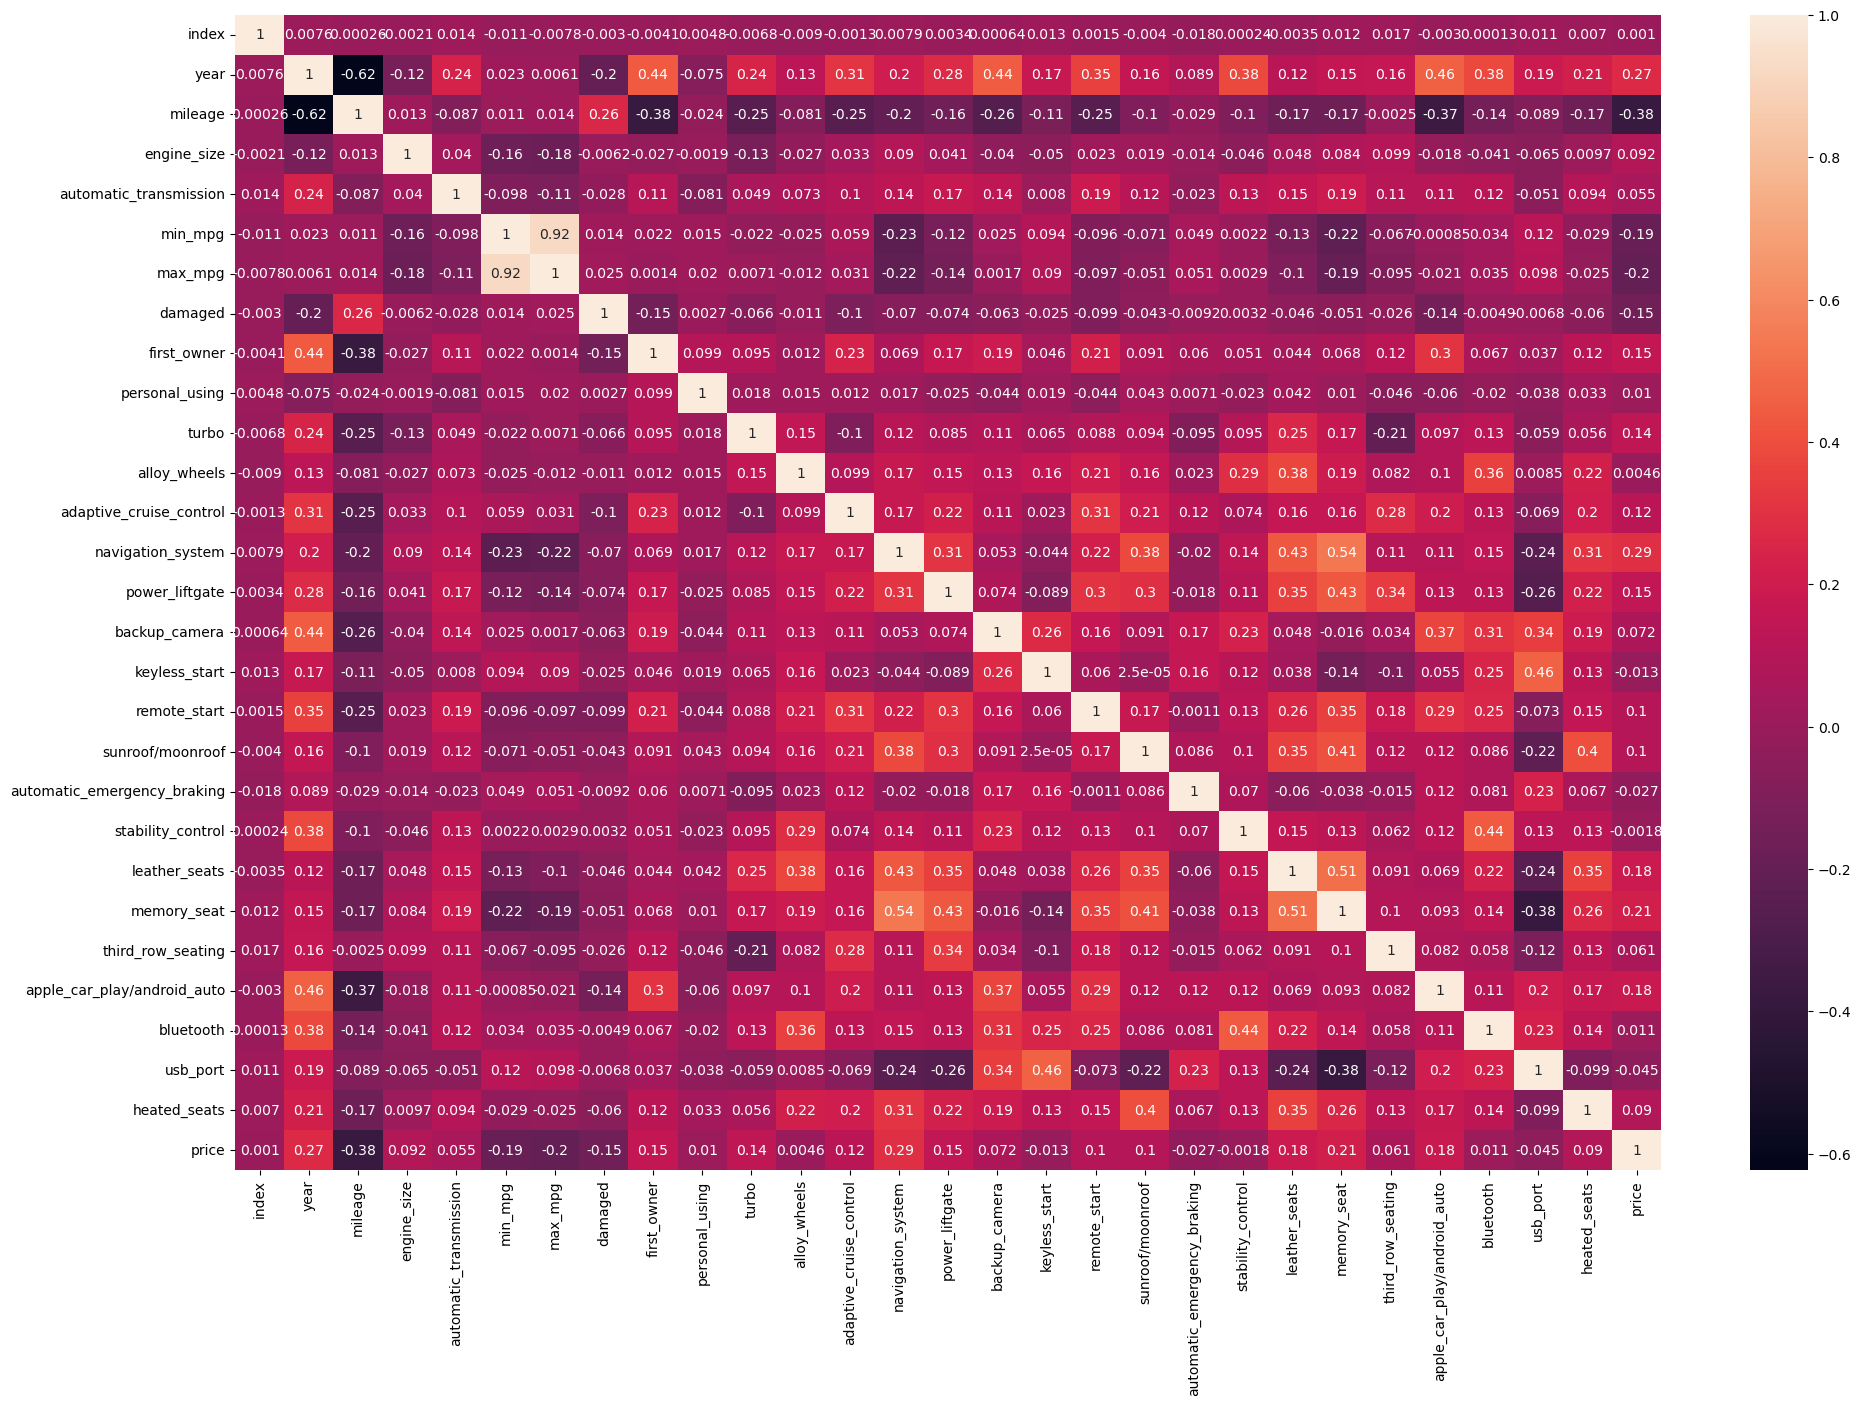

In [19]:
import seaborn as sns

plt.figure(figsize=(23,15))

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [20]:
results = df.corr()[ (df.corr() > 0.5) & (df.corr() != 1) ]
results

,index,year,mileage,engine_size,automatic_transmission,min_mpg,max_mpg,damaged,first_owner,personal_using,...,automatic_emergency_braking,stability_control,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,price
index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engine_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
automatic_transmission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_mpg,NaN,NaN,NaN,NaN,NaN,NaN,0.92187,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_mpg,NaN,NaN,NaN,NaN,NaN,0.92187,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
damaged,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_owner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
personal_using,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

### Features Selection

In [21]:
data_temp = df.select_dtypes(include=np.number)
data_temp.head()

,index,year,mileage,engine_size,automatic_transmission,min_mpg,max_mpg,damaged,first_owner,personal_using,...,automatic_emergency_braking,stability_control,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,price
0,0,2021.0,51299.0,3.5,1.0,19.0,26.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,35999.0
1,1,2014.0,79279.0,4.7,1.0,21.0,28.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,22349.0
2,2,2021.0,31976.0,2.0,1.0,24.0,31.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19499.0
3,3,1994.0,92025.0,3.0,1.0,10.0,16.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12960.0
4,4,2016.0,43418.0,1.5,1.0,21.0,31.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,16500.0


### Model Selection

In [22]:
#Split the labeled data frame into two sets: features and target
X = data_temp.drop('price', axis=1)
y = data_temp[['price']]

print(X.shape, y.shape)

#Split the labeled data frame into two sets to train then test the models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(13987, 28) (13987, 1)


((11189, 28), (11189, 1), (2798, 28), (2798, 1))

In [23]:
X.head(3)

,index,year,mileage,engine_size,automatic_transmission,min_mpg,max_mpg,damaged,first_owner,personal_using,...,sunroof/moonroof,automatic_emergency_braking,stability_control,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats
0,0,2021.0,51299.0,3.5,1.0,19.0,26.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,1,2014.0,79279.0,4.7,1.0,21.0,28.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
2,2,2021.0,31976.0,2.0,1.0,24.0,31.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
y.head(3)

,price
0,35999.0
1,22349.0
2,19499.0


### ML Model

#### LinearRegression

In [25]:
# Set the random_state parameter
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# Make predictions
lr_pred = lr.predict(X_test)
lr_pred_train = lr.predict(X_train)

In [26]:
print('R2 for training data is {}'.format(r2_score(y_train, lr_pred_train)))
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, lr_pred_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, lr_pred_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train, lr_pred_train)))
print('-'*80)

print('R2 for test data: ',r2_score(y_test, lr_pred))
print('RMSE for test data: ', np.sqrt(mean_squared_error(y_test, lr_pred)))
print('MAE for test data: ', mean_absolute_error(y_test,lr_pred))
print('MAPE for test data: ', mean_absolute_percentage_error(y_test, lr_pred))

R2 for training data is 0.22201091927289152
RMSE for training data is 31436.258630249715
MAE for training data is 12034.998002015465
MAPE for training data is 0.4000576446197979
--------------------------------------------------------------------------------
R2 for test data:  0.40989682207449396
RMSE for test data:  18704.72804280245
MAE for test data:  11174.149477662027
MAPE for test data:  0.4014725610193449


#### GradientBoosting

In [27]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_pred_train = gb.predict(X_train)

In [28]:
print('R2 for training data is {}'.format(r2_score(y_train, gb_pred_train)))
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, gb_pred_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, gb_pred_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train, gb_pred_train)))
print('-'*80)

print('R2 for test data: ',r2_score(y_test, gb_pred))
print('RMSE for test data: ', np.sqrt(mean_squared_error(y_test, gb_pred)))
print('MAE for test data: ', mean_absolute_error(y_test,gb_pred))
print('MAPE for test data: ', mean_absolute_percentage_error(y_test, gb_pred))

R2 for training data is 0.7782237449011158
RMSE for training data is 16784.23784549969
MAE for training data is 7193.675324119301
MAPE for training data is 0.20891459806596177
--------------------------------------------------------------------------------
R2 for test data:  0.618086699622207
RMSE for test data:  15047.689215885388
MAE for test data:  7399.513400568824
MAPE for test data:  0.21972347789419183


#### XGB

In [29]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_pred_train = xgb.predict(X_train)

In [30]:
print('R2 for training data is {}'.format(r2_score(y_train, xgb_pred_train)))
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, xgb_pred_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, xgb_pred_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train, xgb_pred_train)))
print('-'*80)

print('R2 for test data: ',r2_score(y_test, xgb_pred))
print('RMSE for test data: ', np.sqrt(mean_squared_error(y_test, xgb_pred)))
print('MAE for test data: ', mean_absolute_error(y_test,xgb_pred))
print('MAPE for test data: ', mean_absolute_percentage_error(y_test, xgb_pred))

R2 for training data is 0.9792701707735751
RMSE for training data is 5131.472011667481
MAE for training data is 3428.042808222466
MAPE for training data is 0.11176072252627783
--------------------------------------------------------------------------------
R2 for test data:  0.6943267855431496
RMSE for test data:  13462.202328017418
MAE for test data:  6071.313999484146
MAPE for test data:  0.19049284246411585


#### LGBM

In [31]:
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_pred_train = lgbm.predict(X_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 11189, number of used features: 28
[LightGBM] [Info] Start training from score 35968.093306


In [32]:
# Print metrics for training data
print('R2 for training data is {}'.format(r2_score(y_train, lgbm_pred_train)))
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, lgbm_pred_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, lgbm_pred_train)))
print('-'*80)

# Print metrics for test data
print('R2 for test data: ', r2_score(y_test, lgbm_pred))
print('RMSE for test data: ', np.sqrt(mean_squared_error(y_test, lgbm_pred)))
print('MAE for test data: ', mean_absolute_error(y_test, lgbm_pred))


R2 for training data is 0.7117689185730132
RMSE for training data is 19134.38499220989
MAE for training data is 5575.7537471407295
--------------------------------------------------------------------------------
R2 for test data:  0.7395439430783571
RMSE for test data:  12426.666757424311
MAE for test data:  6381.713013355011


#### KNN

In [33]:
kn = KNeighborsRegressor()
kn.fit(X_train, y_train)
kn_pred = kn.predict(X_test)
kn_pred_train = kn.predict(X_train)

In [34]:
print('R2 for training data is {}'.format(r2_score(y_train, kn_pred_train)))
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, kn_pred_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, kn_pred_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train, kn_pred_train)))
print('-'*80)

print('R2 for test data: ',r2_score(y_test, kn_pred))
print('RMSE for test data: ', np.sqrt(mean_squared_error(y_test, kn_pred)))
print('MAE for test data: ', mean_absolute_error(y_test,kn_pred))
print('MAPE for test data: ', mean_absolute_percentage_error(y_test, kn_pred))

R2 for training data is 0.39700526527240154
RMSE for training data is 27675.84325652814
MAE for training data is 12033.47750469211
MAPE for training data is 0.36439745670339097
--------------------------------------------------------------------------------
R2 for test data:  -0.029382206779942965
RMSE for test data:  24704.481877550916
MAE for test data:  14293.648677626876
MAPE for test data:  0.4837851527042073


#### Best Model

In [35]:
# Define the pipelines for various models
pipeline_lr = Pipeline([('lr', LinearRegression())])
pipeline_gb = Pipeline([('gb', GradientBoostingRegressor())])
pipeline_xgb = Pipeline([('xgb', XGBRegressor())])
pipeline_lgbm = Pipeline([('lgbm', LGBMRegressor())])
pipeline_knn = Pipeline([('knn', KNeighborsRegressor())])

pipelines = [pipeline_lr, pipeline_gb, pipeline_xgb, pipeline_lgbm, pipeline_knn]

pipe_dict = {
    0: 'Linear Regression',
    1: 'Gradient Boost',
    2: 'XGBoost',
    3: 'LGBM',
    4: 'K-Neighbors Regression'
}

test_score = []
train_score = []
model_list = []

for i, model in enumerate(pipelines):
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    model_list.append(pipe_dict[i])

for i in range(len(model_list)):
    print(f"Model: {model_list[i]}")
    print(f"Training R2 Score: {train_score[i]}")
    print(f"Test R2 Score: {test_score[i]}")
    print("-" * 40)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 11189, number of used features: 28
[LightGBM] [Info] Start training from score 35968.093306
Model: Linear Regression
Training R2 Score: 0.22201091927289152
Test R2 Score: 0.40989682207449396
----------------------------------------
Model: Gradient Boost
Training R2 Score: 0.7782237449011158
Test R2 Score: 0.6194467139760049
----------------------------------------
Model: XGBoost
Training R2 Score: 0.9792701707735751
Test R2 Score: 0.6943267855431496
----------------------------------------
Model: LGBM
Training R2 Score: 0.7117689185730132
Test R2 Score: 0.7395439430783571
----------------------------------------
Model: K-Neighbors Regression
Training R2 Score: 0.397005265

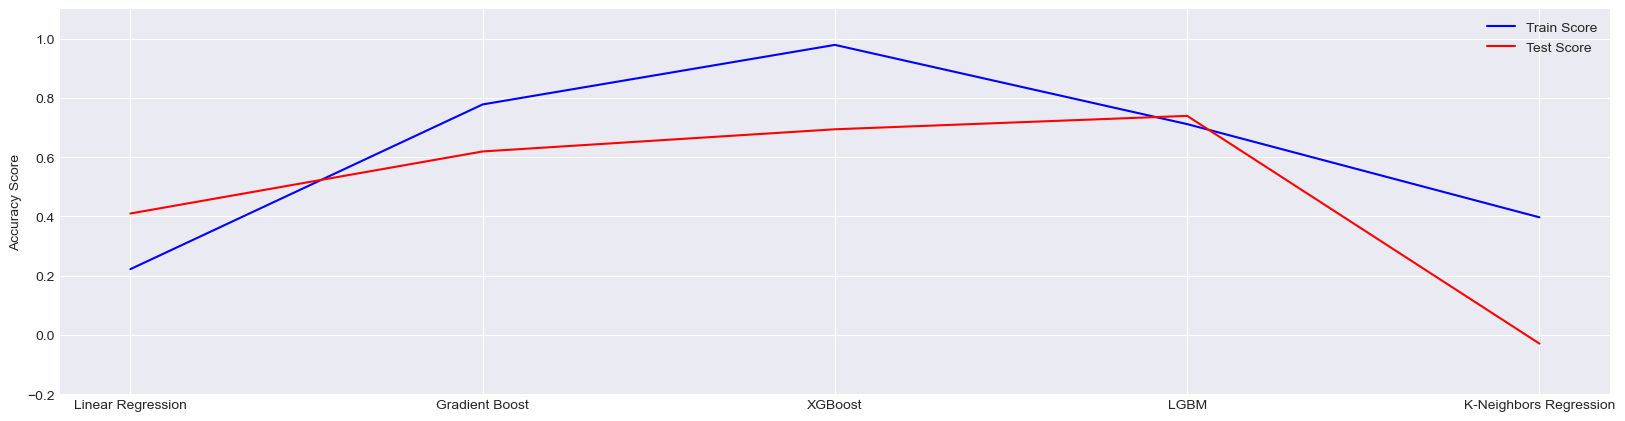

In [36]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(20, 5))
plt.plot(model_list, train_score, color='blue', label='Train Score')
plt.plot(model_list, test_score, color='red', label='Test Score')
plt.ylim(-0.2, 1.1)
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

In [37]:
for i, model in enumerate(pipelines):
    print(f'{pipe_dict[i]} has train accuracy: {round(model.score(X_train, y_train),3)}')
    print(f'{pipe_dict[i]} has test accuracy: {round(model.score(X_test, y_test),3)}')
    print('')

Linear Regression has train accuracy: 0.222
Linear Regression has test accuracy: 0.41

Gradient Boost has train accuracy: 0.778
Gradient Boost has test accuracy: 0.619

XGBoost has train accuracy: 0.979
XGBoost has test accuracy: 0.694

LGBM has train accuracy: 0.712
LGBM has test accuracy: 0.74

K-Neighbors Regression has train accuracy: 0.397
K-Neighbors Regression has test accuracy: -0.029



#### Evaluation Model

##### Metrics

In [38]:
from matplotlib import legend
from sklearn.metrics import mean_squared_error as MSE

# Function for evaluation metric for regression
def EvaluationMetric(Xt, yt, yp, disp="on"):
  
  ''' Take the different set of parameter and prints evaluation metrics '''
  MSE = round(mean_squared_error(y_true=yt, y_pred=yp), 4)
  RMSE = (np.sqrt(MSE))
  R2 = (r2_score(y_true=yt, y_pred=yp))
  Adjusted_R2 = (1-(1-r2_score(yt, yp))*((Xt.shape[0]-1)/(Xt.shape[0]-Xt.shape[1]-1)))
  if disp=="on":
    print("MSE :",MSE,"RMSE :", RMSE)
    print("R2 :",R2,"Adjusted R2 :",Adjusted_R2)

  #Plotting Actual and Predicted Values
  plt.figure(figsize=(18,6))
  plt.plot((yp)[:100]) 
  plt.plot((np.array(yt)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual and Predicted Time Duration')

  return (MSE, RMSE, R2, Adjusted_R2) 

##### LGBMRegressor + Hyperparameter Tuning

In [39]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

n_estimator=[3, 5, 10, 15]
max_depth=[7, 9, 13, 15]
min_samples_split=[30, 40, 50]
params={"n_estimator":n_estimator,
        "max_depth":max_depth,
        "min_samples_split":min_samples_split
        }

lgb = LGBMRegressor(random_state=42)
gs_lgb = GridSearchCV(lgb, params, cv=5, verbose=2, scoring='r2')
gs_lgb.fit(X_train,y_train)

print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 8951, number of used features: 28
[LightGBM] [Info] Start training from score 36115.245001
[LightGBM] [Warning] No further splits with pos

In [40]:
print(gs_lgb.best_estimator_)
gs_lgb_opt_model = gs_lgb.best_estimator_
y_preds_lgb = gs_lgb_opt_model.predict(X_test)
y_pred_lgb_train=gs_lgb_opt_model.predict(X_train)

LGBMRegressor(max_depth=15, min_samples_split=30, n_estimator=3,
              random_state=42)
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


MSE : 366124689.0301 RMSE : 19134.384992209703
R2 : 0.7117689185730132 Adjusted R2 : 0.7110457581536622


(366124689.0301, 19134.384992209703, 0.7117689185730132, 0.7110457581536622)

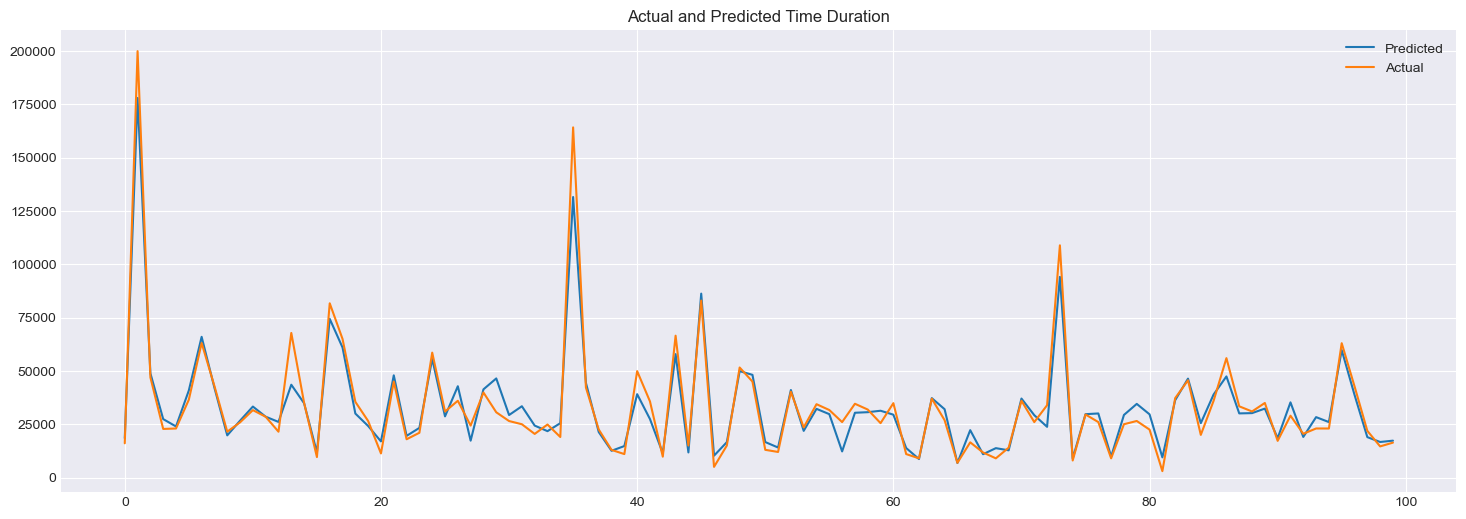

In [41]:
#Evaluation metrics for Train set
EvaluationMetric(X_train,y_train,y_pred_lgb_train)

MSE : 154422046.7001 RMSE : 12426.666757425339
R2 : 0.7395439430783571 Adjusted R2 : 0.7369102234706266


(154422046.7001, 12426.666757425339, 0.7395439430783571, 0.7369102234706266)

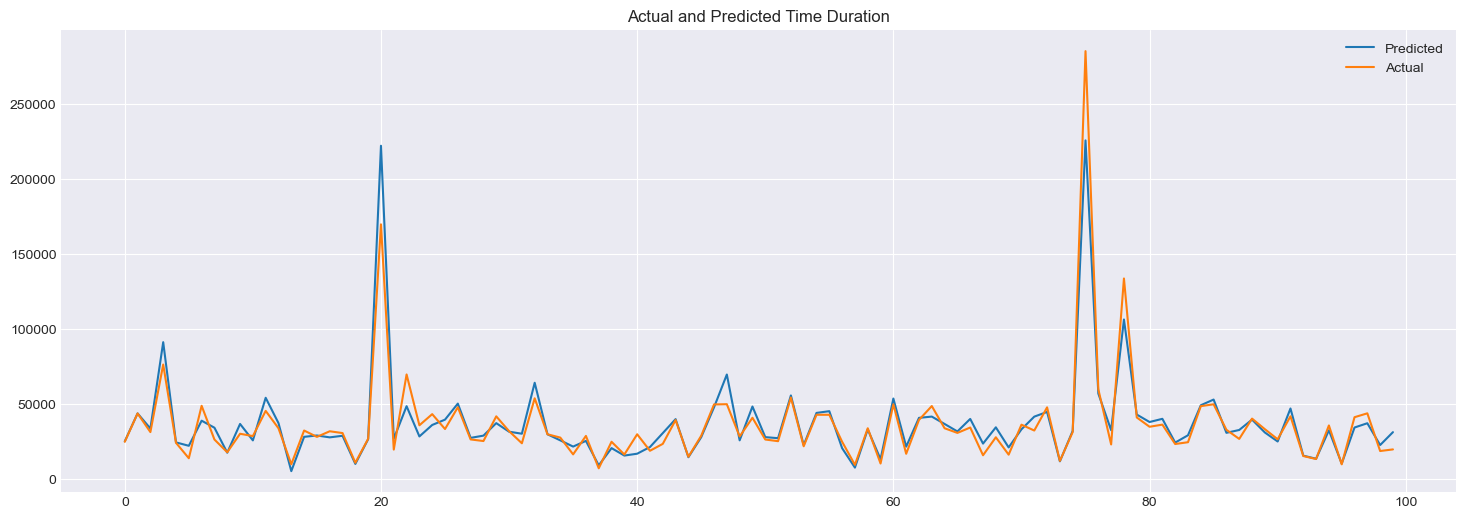

In [42]:
#Evaluation metrics for Test set
EvaluationMetric(X_test,y_test,y_preds_lgb)

##### Cross Validation

In [43]:
from sklearn.model_selection import cross_val_score

regressor = LGBMRegressor()

# Menjalankan cross validation dengan 5 fold
scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Menghitung nilai MSE, RMSE, dan MAE dari cross validation scores
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
mae_scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_absolute_error')

# Menampilkan hasil evaluasi dari cross validation
print("Cross Validation Results:")
print(f"MSE Scores: {mse_scores}")
print(f"RMSE Scores: {rmse_scores}")
print(f"MAE Scores: {mae_scores}")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 11189, number of used features: 28
[LightGBM] [Info] Start training from score 35469.744481
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 11189, number of used features: 28
[LightGBM] [Info] Start training from score 35736.849048
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo